In [2]:
import os
from pathlib import Path

import cv2
import scipy
import numpy as np
from PIL import Image

import tensorrt as trt
import pycuda.autoinit # Don't remove this line
import pycuda.driver as cuda

from torchvision import transforms

In [7]:
input_size = (288, 800)
image_size = (480, 640)
trt_engine_path = "/home/ircv/projects/deep_daiv/lane/Ultra-Fast-Lane-Detection/epoch_99.trt"

num_grid = 100
num_lanes = 2
cls_num_per_lane = 56
row_anchor = [
    64,  68,  72,  76,  80,  84,  88,  92,  96,  100, 104, 108, 112,
    116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164,
    168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216,
    220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268,
    272, 276, 280, 284
]

In [8]:
# Load the TensorRT engine
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
engine = runtime.deserialize_cuda_engine(open(trt_engine_path, 'rb').read())
context = engine.create_execution_context()
print(f"Engine loaded from {trt_engine_path}")

# Allocate pagelocked memory
h_input = cuda.pagelocked_empty(trt.volume((1, 3, input_size[0], input_size[1])), dtype=np.float32)
h_output = cuda.pagelocked_empty(trt.volume((1, num_grid + 1, len(row_anchor), num_lanes)), dtype=np.float32)

# Allocate device memory
d_input = cuda.mem_alloc(h_input.nbytes)
d_output = cuda.mem_alloc(h_output.nbytes)

# Create a cuda stream
cuda_stream = cuda.Stream()

[01/05/2025-23:36:54] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
Engine loaded from /home/ircv/projects/deep_daiv/lane/Ultra-Fast-Lane-Detection/epoch_99_jjuu.trt


In [9]:
image_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [20]:
def rescale_row_anchor(row_anchor, input_size, image_size):
    scale_f = lambda x : int((x * 1.0/input_size[0]) * image_size[0])
    return list(map(scale_f, row_anchor))

def preprocess(
    image: np.ndarray,
    input_size: tuple,
    mean: np.ndarray = np.array([0.485, 0.456, 0.406]),
    std: np.ndarray = np.array([0.229, 0.224, 0.225])
):
    # Resize the image
    image = cv2.resize(image, input_size[::-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)
    # Normalize the image
    image = image / 255.0
    image = (image - mean) / std
    # Expand the dimension of the image
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, axis=0)

    print(image.shape)

    return image

# def preprocess(image: Image):
#     image = image_transform(image)
#     image = np.array(image)
#     image = np.expand_dims(image, axis=0)
#     return image

In [21]:
image_path = "/home/ircv/projects/deep_daiv/lane/Ultra-Fast-Lane-Detection/img1.jpg"

# Load the image
image = cv2.imread(image_path) # numpy
# image = Image.open(image_path) # PIL

# Preprocess the image
image = preprocess(image, input_size)
# image = preprocess(image)

### Inference

# Copy the image to the pagelocked memory
np.copyto(h_input, image.ravel())

# Copy the pagelocked memory to the device memory
cuda.memcpy_htod_async(d_input, h_input, cuda_stream)
context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=cuda_stream.handle)
cuda.memcpy_dtoh_async(h_output, d_output, cuda_stream)
cuda_stream.synchronize()

(1, 3, 288, 800)


In [22]:
h_output[:10]

array([-0.21887207, -0.53564453, -0.28710938, -0.20898438, -0.23852539,
       -0.26708984, -0.00054932, -0.45263672,  0.23962402, -0.53271484],
      dtype=float32)

In [23]:
h_output.shape

(11312,)

In [24]:
outputs = h_output.reshape((num_grid + 1, len(row_anchor), num_lanes))
outputs.shape

(101, 56, 2)

In [25]:
rescaled_row_anchor = rescale_row_anchor(row_anchor, input_size, image_size)

In [26]:
rescaled_row_anchor[:10]

[106, 113, 120, 126, 133, 140, 146, 153, 160, 166]

In [27]:
def postprocess(outputs, image_size, rescaled_row_anchor, num_grid):
    # Get the lane lines
    out_loc = np.argmax(outputs, axis=0)
    prob = scipy.special.softmax(outputs[:-1, :, :], axis=0)
    idx = np.arange(num_grid)
    idx = idx.reshape(-1, 1, 1)

    loc = np.sum(prob * idx, axis=0)
    loc[out_loc == num_grid] = num_grid
    out_loc = loc

    lanes = []
    for i in range(out_loc.shape[1]):
        out_i = out_loc[:, i]
        lane = [int(round((loc + 0.5) * image_size[1] / (num_grid - 1))) if loc != num_grid else -2 for loc in out_i]
        lanes.append(lane)

    coords = []
    for lane in lanes:
        coord = []
        for i, y in enumerate(rescaled_row_anchor):
            if lane[i] == -2:
                continue
            coord.append((lane[i], y))
        coords.append(coord)

    return coords

In [28]:
coords = postprocess(outputs, image_size, rescaled_row_anchor, num_grid)

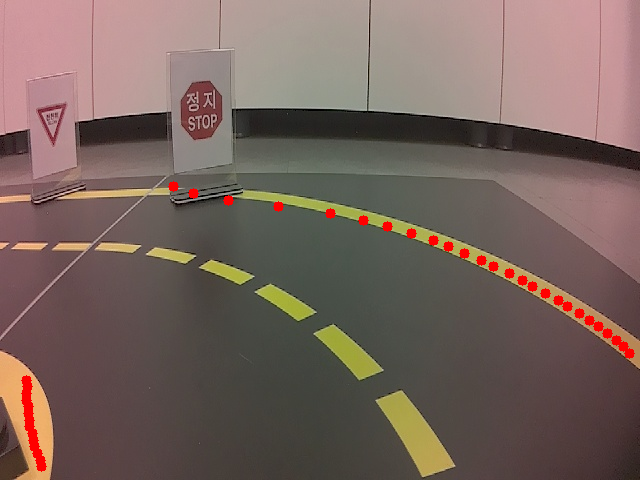

In [29]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for coord in coords:
    for i in range(len(coord) - 1):
        cv2.circle(image, coord[i], 5, (255, 0, 0), -1)
Image.fromarray(image)